In [1]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [2]:
now = datetime.datetime.now()

In [3]:
train_df = pd.read_csv('dataset/train_16_0246.csv')
test_df = pd.read_csv('dataset/test_16_0246.csv')

In [4]:
ID = test_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']
test_df = test_df.drop(columns=['y', 'id'])

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=18)

In [6]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=18)

# ・LightGBM

In [7]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [8]:
es = 100

lgb_model = lgb.LGBMClassifier(n_estimators=10000, random_state=18, n_jobs=-1)
lgb_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=es, verbose=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.208234
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.207902


LGBMClassifier(n_estimators=10000, random_state=18)

In [9]:
train_score_lgb = lgb_model.score(x_train, y_train)
test_score_lgb = lgb_model.score(x_test, y_test)

lgb_p = lgb_model.predict(x_test)

acc_lgb = accuracy_score(lgb_p, y_test)
auc_lgb = roc_auc_score(lgb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_lgb, test_score_lgb))
print('acc:{}, auc:{}'.format(acc_lgb, auc_lgb))

train score:0.9435885608856088, test_score:0.9306273062730628
acc:0.9306273062730628, auc:0.8153942548063091


In [15]:
%%time

params_lgb = {
    'boosting': ['gbdt'],
    'n_estimations': [10000],
    'learning_rate': [i for i in np.arange(0.01, 0.03, 0.01)],
    'num_leaves': [i for i in range(20, 30, 2)],
    'max_depth': [7],
    'metric': ['auc'],
    'min_child_weight': [i for i in np.arange(1, 5)],
    'min_child_samples': [i for i in range(10, 30, 10)],
    'colsample_bytree': [i for i in np.arange(0.90, 1.00, 0.05)],
    'subsample': [i for i in np.arange(0.80, 1.00, 0.05)],
    'seed': [18],
    'verbosity': [-1]
}

lgb_model = lgb.LGBMClassifier()
gs_lgb = GridSearchCV(lgb_model, param_grid=params_lgb, scoring='roc_auc', cv=skf, n_jobs=-1)
gs_lgb.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=es)

print(gs_lgb.best_score_)
print(gs_lgb.best_params_)

[1]	valid_0's auc: 0.774937
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.776877
[3]	valid_0's auc: 0.778518
[4]	valid_0's auc: 0.781526
[5]	valid_0's auc: 0.793532
[6]	valid_0's auc: 0.794198
[7]	valid_0's auc: 0.799343
[8]	valid_0's auc: 0.799231
[9]	valid_0's auc: 0.799395
[10]	valid_0's auc: 0.802064
[11]	valid_0's auc: 0.802221
[12]	valid_0's auc: 0.802827
[13]	valid_0's auc: 0.806054
[14]	valid_0's auc: 0.805915
[15]	valid_0's auc: 0.806502
[16]	valid_0's auc: 0.807497
[17]	valid_0's auc: 0.80781
[18]	valid_0's auc: 0.807833
[19]	valid_0's auc: 0.808414
[20]	valid_0's auc: 0.808138
[21]	valid_0's auc: 0.809466
[22]	valid_0's auc: 0.810482
[23]	valid_0's auc: 0.810987
[24]	valid_0's auc: 0.811185
[25]	valid_0's auc: 0.811495
[26]	valid_0's auc: 0.81131
[27]	valid_0's auc: 0.811236
[28]	valid_0's auc: 0.811477
[29]	valid_0's auc: 0.811954
[30]	valid_0's auc: 0.812166
[31]	valid_0's auc: 0.812139
[32]	valid_0's auc: 0.81198
[33]	valid_0's auc: 0.

In [16]:
lgb_best_params = {
    'boosting': 'gbdt',
    'n_estimators': 10000,
    'feature_fraction': 0.9,
    'learning_rate': 0.02,
    'num_leaves': 28,
    'max_depth': 7,
    'min_child_weight': 1,
    'min_child_samples': 10,
    'subsample': 0.8,
    'random_state': 18,
}

best_lgb = lgb.LGBMClassifier(**lgb_best_params)
best_lgb.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=es)

[1]	valid_0's binary_logloss: 0.270471
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.267815
[3]	valid_0's binary_logloss: 0.265407
[4]	valid_0's binary_logloss: 0.263764
[5]	valid_0's binary_logloss: 0.261925
[6]	valid_0's binary_logloss: 0.26017
[7]	valid_0's binary_logloss: 0.258353
[8]	valid_0's binary_logloss: 0.257031
[9]	valid_0's binary_logloss: 0.255568
[10]	valid_0's binary_logloss: 0.254064
[11]	valid_0's binary_logloss: 0.25274
[12]	valid_0's binary_logloss: 0.251323
[13]	valid_0's binary_logloss: 0.250094
[14]	valid_0's binary_logloss: 0.248867
[15]	valid_0's binary_logloss: 0.247655
[16]	valid_0's binary_logloss: 0.246529
[17]	valid_0's binary_logloss: 0.245438
[18]	valid_0's binary_logloss: 0.244627
[19]	valid_0's binary_logloss: 0.243706
[20]	valid_0's binary_logloss: 0.242742
[21]	valid_0's binary_logloss: 0.241996
[22]	valid_0's binary_logloss: 0.241064
[23]	valid_0's binary_logloss: 0.240196
[24]	valid_0's binary_logloss

LGBMClassifier(boosting='gbdt', feature_fraction=0.9, learning_rate=0.02,
               max_depth=7, min_child_samples=10, min_child_weight=1,
               n_estimators=10000, num_leaves=28, random_state=18,
               subsample=0.8)

In [17]:
train_score_gslgb = best_lgb.score(x_train, y_train)
test_score_gslgb = best_lgb.score(x_test, y_test)

gslgb_p = best_lgb.predict(x_test)

acc_gslgb = accuracy_score(gslgb_p, y_test)
auc_gslgb = roc_auc_score(gslgb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_gslgb, test_score_gslgb))
print('acc:{}, auc:{}'.format(acc_gslgb, auc_gslgb))

train score:0.9406826568265683, test_score:0.9313653136531366
acc:0.9313653136531366, auc:0.8276099219023814


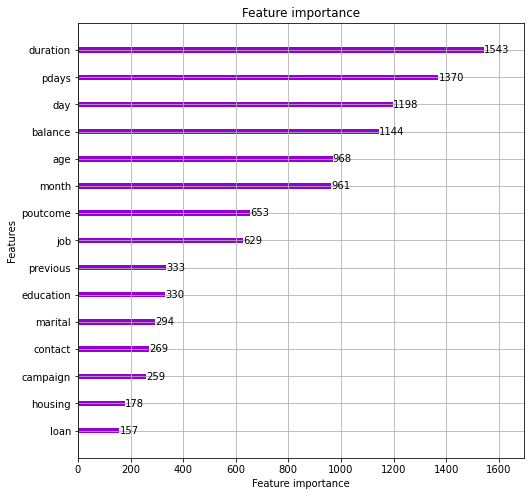

In [18]:
lgb.plot_importance(best_lgb, figsize=(8,8), color='darkviolet')

In [19]:
pred_lgb = best_lgb.predict_proba(test_df)
lgb_p = pd.DataFrame(pred_lgb)
lgb_p.head()

,0,1
0,0.176083,0.823917
1,0.874235,0.125765
2,0.968224,0.031776
3,0.997868,0.002132
4,0.978072,0.021928


In [23]:
lgb_name = 'models/LGBM_grid' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(best_lgb, open(lgb_name, 'wb'))

# ・SUBMIT

In [ ]:
pred = pd.DataFrame({
    'LightGBM': lgb_p[1]
})

pred.head()

In [ ]:
pred['sum'] = pred.sum(axis=1)
pred['pred'] = pred.RandomForest * 0.2 + pred.LightGBM * 0.8
pred.head()

In [ ]:
submission = pd.DataFrame({
    'ID':ID,
    'pred':pred['pred']
})

file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

In [21]:
# LightGBM

submission = pd.DataFrame({
    'ID':ID,
    'pred':lgb_p[1]
})

file_name = 'submit/submit_LGBM' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)